# Keras LSTM

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1, Load the data

In [3]:
from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

#import numpy as np
#
##df = pd.read_csv('vattenfall_turbine.csv')
#keys = df.keys().values
#feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
#time_key = keys[0]

In [3]:
################# IN case not by Colab #########
import numpy as np

df = pd.read_csv(r'E:\FEM\Python\bitbucket\Vattenfall_rnn\vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[0]

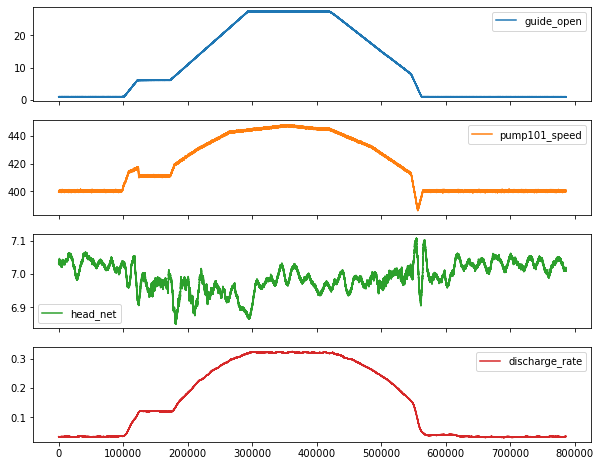

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

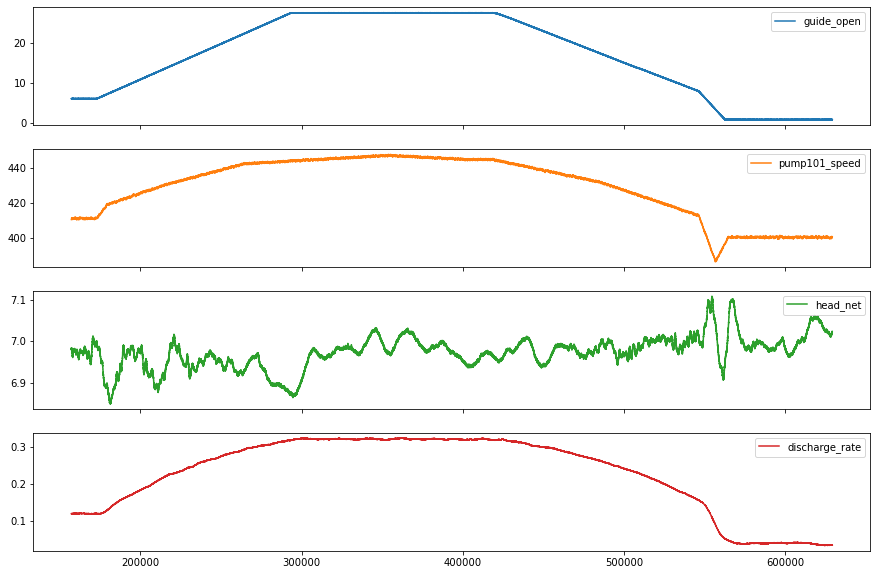

In [4]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True, figsize=(10, 8))
plt.show()

from IPython.display import display, Markdown
#display(Markdown(' <font size="6"><span style="color:blue">**Lets take a close look at the time series.**</span> </font>'))

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

plot_features = df[plot_cols][int(len(df)/5):int(len(df)*4/5):10]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True, figsize=(15, 10))

## 2, Preprocessing data: normalize, train, validation, test, etc.

### 2.1, resample the data with low-resolution

<span style="color:red; font-size:30px">**No. of the values in the training dataset is: 47186**</span>

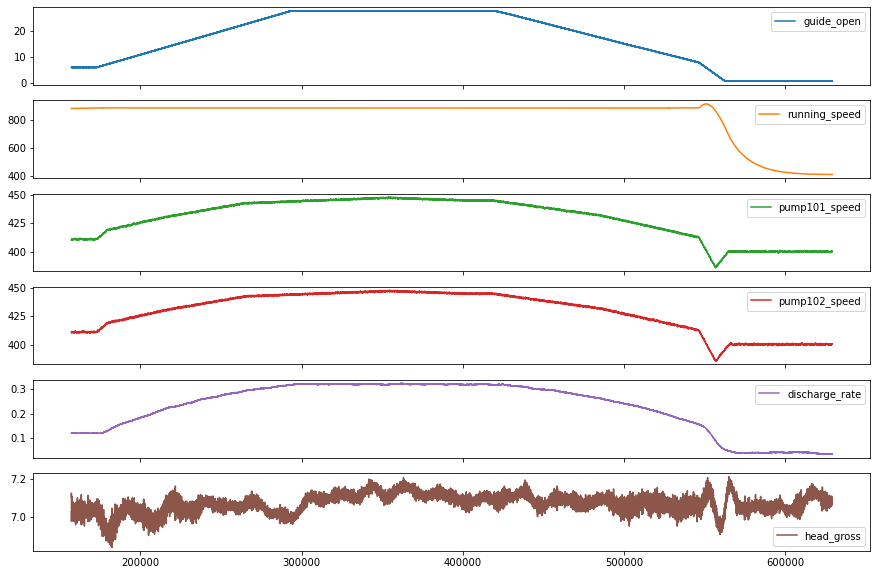

<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>

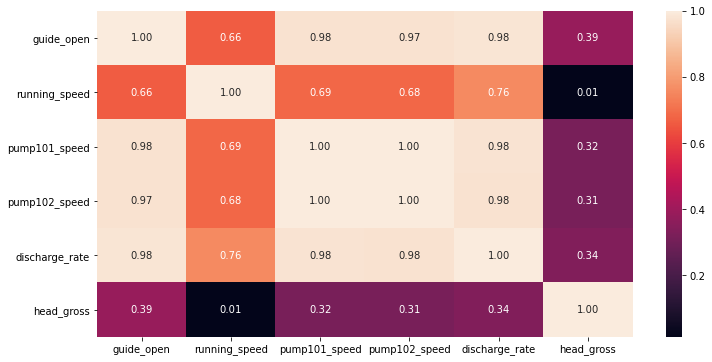

In [5]:
df_train = df[feature_keys[[0, 1, 2, 3]+[6]+[5]]][int(len(df)*0.2):int(len(df)*0.8):10]
display(Markdown('<span style="color:red; font-size:30px">**No. of the values in the training dataset is: %d**</span>' %len(df_train)))

# plot the data and check their variations along time
df_train.plot(subplots=True, figsize=(15, 10))
plt.show()
#print('No. of the values in the training dataset is: %d' %len(df_train))

display(Markdown('<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>'))
# check he correlation
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")
plt.show()

### 2.2, normalize the data

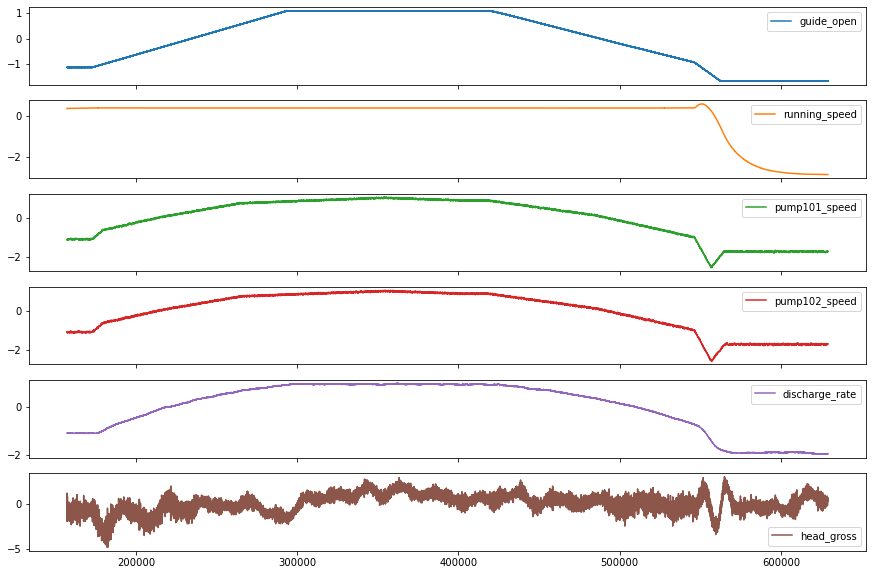

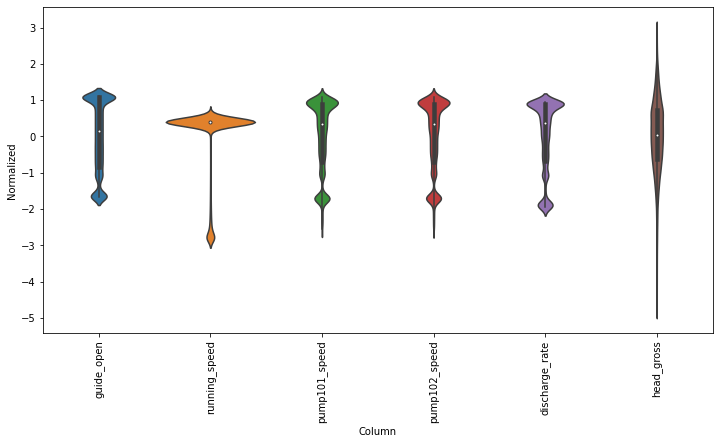

In [6]:
# First, we assume all data are used for the training (the time series is not that stationary for the prediction)
df_train_mean = df_train.mean()
df_train_std = df_train.std()
train_df = (df_train-df_train_mean) / df_train_std

fig2 = train_df.plot(subplots=True,figsize=(15,10))

# Second, plot the standand deviation of features within this dataframe
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(train_df.keys(), rotation=90)

 ##  3, Analysis: step = 1; past =100; future = 10 <font color ='blue'>  **(2021-11-05)**</font>

In [7]:
df_train = df_train.reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train.shape[0]*split_fraction)
past = 100
future = 10
step = 1
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train.loc[0:train_split-1]
val_data = df_train.loc[train_split:]

In [8]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

(50, 100, 6)
(50, 1)


In [9]:
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 6)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
753/753 [==============================] - 8s 7ms/step - loss: 3.1805 - val_loss: 1.3407

Epoch 00001: val_loss improved from inf to 1.34072, saving model to model_checkpoint.h5
Epoch 2/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 1.3457

Epoch 00002: val_loss did not improve from 1.34072
Epoch 3/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0013 - val_loss: 1.3575

Epoch 00003: val_loss did not improve from 1.34072
Epoch 4/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0013 - val_loss: 1.3697

Epoch 00004: val_loss did not improve from 1.34072
Epoch 5/10
753/753 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 1.3746

Epoch 00005: val_loss did not improve from 1.34072
Epoch 6/10
753/753 [==============================] - 5s 7ms/step - loss: 9.9973e-04 - val_loss: 1.3843

Epoch 00006: val_loss did not improve from 1.34072


In [11]:
! nvcc --version
! /opt/bin/nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:18:57_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0


The system cannot find the path specified.


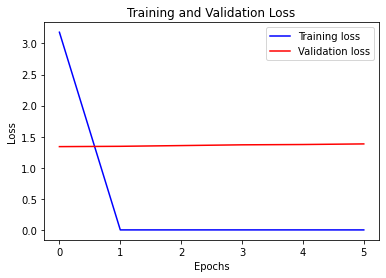

In [12]:
# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



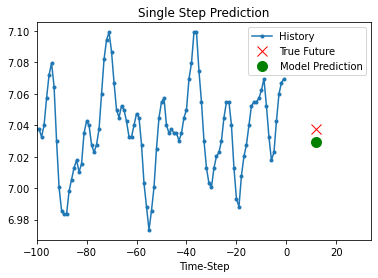

The actual value is: [7.03749], while the predicted value is: [7.029217]


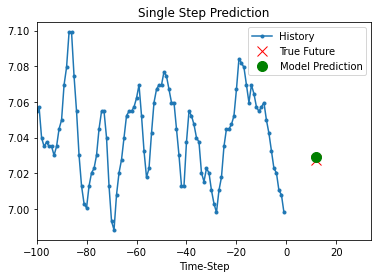

The actual value is: [7.0276425], while the predicted value is: [7.029217]


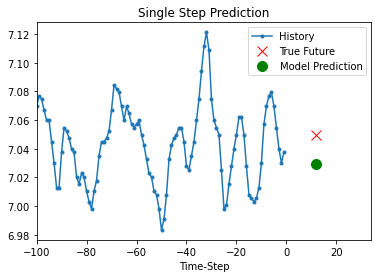

The actual value is: [7.049805], while the predicted value is: [7.029217]


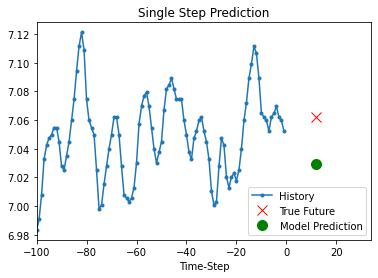

The actual value is: [7.06212], while the predicted value is: [7.029217]


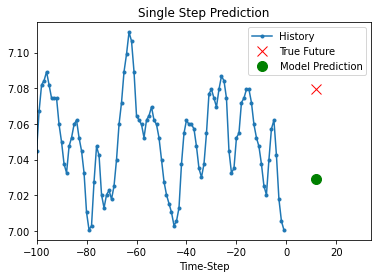

The actual value is: [7.0793625], while the predicted value is: [7.029217]


In [13]:
# Prediciton
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )
    print(f"The actual value is: {y[0].numpy()}, while the predicted value is: {model.predict(x)[0]}")

 ##  4, Analysis: step = 10; past =1000; future = 10 <font color ='blue'>  **(2021-11-06)**</font>

In [14]:
df_train = df_train.reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train.shape[0]*split_fraction)
past = 1000
future = 10
step = 10
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train.loc[0:train_split-1]
val_data = df_train.loc[train_split:]

(50, 100, 6)
(50, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 6)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
735/735 [==============================] - 6s 7ms/step - loss: 1.6749 - val_loss: 5.9166

Epoch 00001: val_loss improved from inf to 5.91663, saving model to model_checkpoint.h5
Epoch 2/10
735/735 [==============================] - 5s 7ms/step - loss: 0.0013 - val_loss: 5.9464

Epoch 00002: val_loss did not improve from 5.91663
Epoch 3/10
735/735 [=====

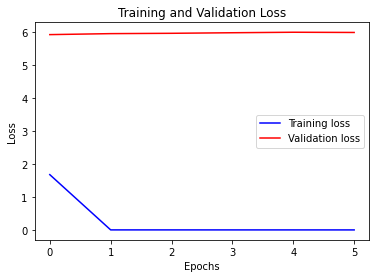

In [15]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

## Construct the model
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


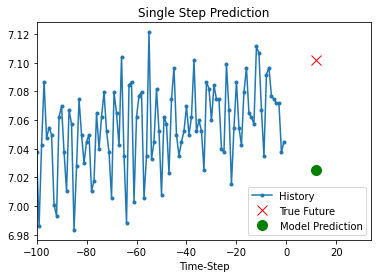

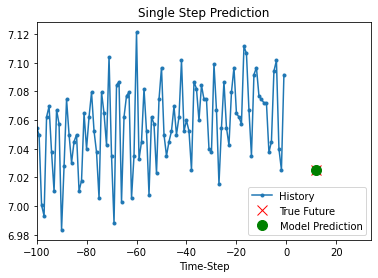

In [16]:
for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

 ##  5, Analysis: step = 10; past =100; future = 10 <font color ='blue'>  **(2021-11-06)**</font>

In [17]:
df_train = df_train.reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train.shape[0]*split_fraction)
past = 100
future = 10
step = 10
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train.loc[0:train_split-1]
val_data = df_train.loc[train_split:]

(50, 10, 6)
(50, 1)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 6)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
753/753 [==============================] - 5s 5ms/step - loss: 2.5029 - val_loss: 0.4215

Epoch 00001: val_loss improved from inf to 0.42147, saving model to model_checkpoint.h5
Epoch 2/10
753/753 [==============================] - 3s 5ms/step - loss: 0.0012 - val_loss: 0.4271

Epoch 00002: val_loss did not improve from 0.42147
Epoch 3/10
753/753 [======

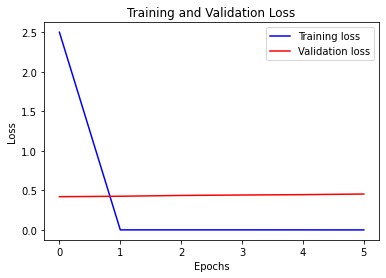

In [18]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

## Construct the model
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


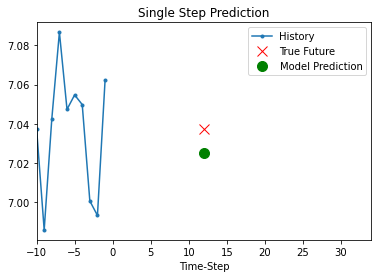

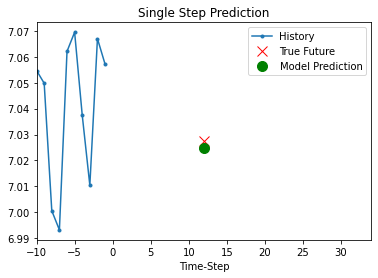

In [19]:
for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

 ##  6, Analysis: step = 1; past =1000; future = 10 <font color ='blue'>  **(2021-11-06)**</font>

In [20]:
df_train = df_train.reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train.shape[0]*split_fraction)
past = 1000
future = 10
step = 1
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train.loc[0:train_split-1]
val_data = df_train.loc[train_split:]

(50, 1000, 6)
(50, 1)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 6)]         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
735/735 [==============================] - 26s 34ms/step - loss: 1.7236 - val_loss: 3.6228

Epoch 00001: val_loss improved from inf to 3.62276, saving model to model_checkpoint.h5
Epoch 2/10
735/735 [==============================] - 24s 33ms/step - loss: 0.0013 - val_loss: 3.6557

Epoch 00002: val_loss did not improve from 3.62276
Epoch 3/10
735/735 [

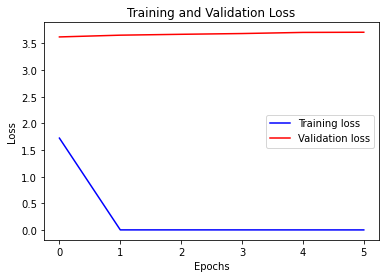

In [21]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

## Construct the model
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


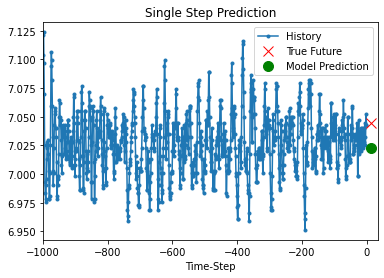

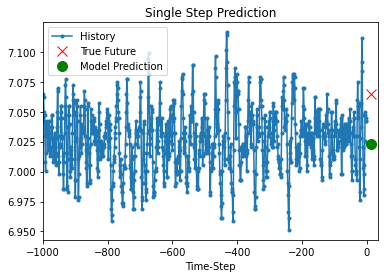

In [22]:
for x, y in dataset_train.take(2):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

## 7, Here we will try to resample the data with $interval =10$ and set step =1

In [23]:
df_train = df_train.reset_index(drop=True)

# Change the time interval
df_train_resample = df_train[0:len(df_train):10].reset_index(drop=True)

split_fraction = 0.8
train_split = int(df_train_resample.shape[0]*split_fraction)
past = 20
future = 1
step = 1
learning_rate = 0.01
batch_size = 50
epochs = 10


train_data = df_train_resample.loc[0:train_split-1]
val_data = df_train_resample.loc[train_split:]




(50, 20, 6)
(50, 1)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
76/76 [==============================] - 2s 9ms/step - loss: 21.8318 - val_loss: 16.7973

Epoch 00001: val_loss improved from inf to 16.79725, saving model to model_checkpoint.h5
Epoch 2/10
76/76 [==============================] - 0s 6ms/step - loss: 1.1807 - val_loss: 9.7418

Epoch 00002: val_loss improved from 16.79725 to 9.74181, saving model to model

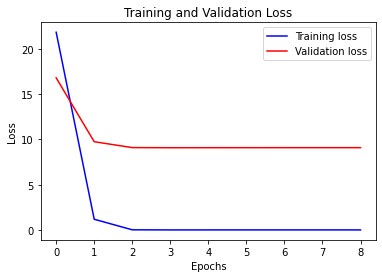

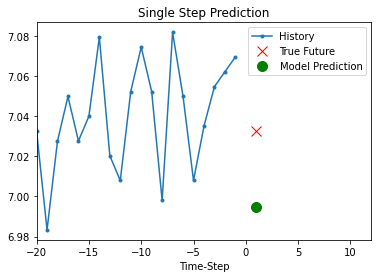

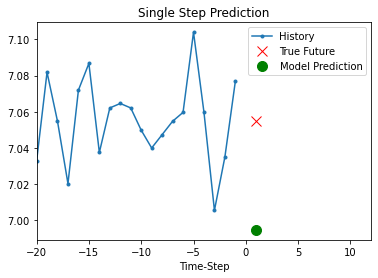

In [24]:
# Prepare training dataset
start = past + future
end = start + train_split
x_train = train_data.values
y_train = df_train.iloc[start:end]['head_gross'].values
y_train = y_train[:, np.newaxis]

sequence_length = int(past/step)

dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Prepare validation dataset
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = val_data.loc[label_start:]['head_gross'].values
y_val = y_val[:, np.newaxis]


dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length = sequence_length,
    sampling_rate=step,
    batch_size = batch_size,
)

# Print the dimension of the inputs and targets 

for batch in dataset_train.take(1):
  inputs, targets = batch

print(inputs.numpy().shape)
print(targets.numpy().shape)

## Construct the model
# Construct the model
from tensorflow import keras
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()


# Estimate the LSTM model
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

# Visualize the results
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# plot the modelling history results
visualize_loss(history, "Training and Validation Loss")

# plot the prediction results
for x, y in dataset_val.take(2):
    show_plot(
        [x[0][:, 5].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,
        "Single Step Prediction",
    )

# <span style = "color: blue; font-size: 30px;  font-weight: 800"> 2, Complete procedure to run Keras model</span>

In [25]:
# 1, read the data


# 2, organize the data

# 3, prepare the model

# 4, run the ML

# 5, check the results